In [1]:
# Import important packages
import numpy as np
import yaml
from bokeh.io import curdoc
from bokeh.layouts import column, row
from bokeh.models import ColumnDataSource, Slider, TextInput, PreText, DataTable, Select
from bokeh.plotting import figure, curdoc
from bokeh.themes import Theme

from pytmatrix.tmatrix import Scatterer
from pytmatrix.psd import PSDIntegrator, GammaPSD
from pytmatrix import orientation, radar, tmatrix_aux, refractive

import pandas as pd
pd.options.display.float_format = '{:,.3f}'.format
from scipy.special import gamma
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [2]:
from dask.distributed import Client
# Try setting up a port using -L to get the dashboard to work
client = Client()  # set up local cluster on your machine
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 124.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44477,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 124.00 GiB
Comm: tcp://127.0.0.1:34311,Total threads: 1
Dashboard: http://127.0.0.1:45651/status,Memory: 31.00 GiB
Nanny: tcp://127.0.0.1:39703,


(1) Load the radar_parameters.csv and Split the data into a 70-30 split for training and testing data.

In [3]:
# Load in radar_parameters.csv and split the training and testing data 70/30
data = pd.read_csv('radar_parameters.csv')
features = ['Zh (dBZ)', 'Zdr (dB)', 'Ldr (dB)', 'Kdp (deg km-1)', 'Ah (dBZ/km)', 'Adr (dB/km)']
target = 'R (mm/hr)'
X = data[features]
y = data[target]
X1, X2, y1, y2 = train_test_split(X, y, random_state=0, train_size=0.7)

(2) Using the split created in (1), train a multiple linear regression dataset using the training dataset, and validate it using the testing dataset. Compare the R2 and root-mean square errors of model on the training and testing sets to a baseline prediction of rain rate using the formula: 
Z = 200R^(1.6)

Z is a reflectivity factor and is used to calculate Zh (dBZ), which is one of the features in the dataset.

Zh​=10log10​(Z)

The inverse of this equation gives us the reflectivity factor:
Z=10^(Zh/10)

Z then gets inserted into the inverse of the equation, a form of the Marshall-Palmer relationship, given to us in this question:
R = (Z/200)^(1/1.6)

In [4]:
# fit the model on one set of data
model = LinearRegression()
model.fit(X1, y1)

# evaluate the model on the second set of data
y2_model = model.predict(X2)

rmse = np.sqrt(mean_squared_error(y2, y2_model))
r2 = r2_score(y2, y2_model)
print(f"Root Mean Squared Error between testing and training dataset: {rmse}")
print(f"R-squared between testing and training dataset: {r2}")


# Set up the baseline prediction and calculate the reflectivity factor
Zh_train = X1['Zh (dBZ)']
Zh_test = X2['Zh (dBZ)']
Z_train = 10**(Zh_train/10)
R_train = (Z_train/200)**(1/1.6)
Z_test = 10**(Zh_test/10)
R_test = (Z_test/200)**(1/1.6)

# Calculate rmse and r2 between R and the training dataset
rmse_train = np.sqrt(mean_squared_error(y1, R_train))
r2_train = r2_score(y1, R_train)
print(f"Root Mean Squared Error between training and R: {rmse_train}")
print(f"R-squared between training and R: {r2_train}")

# Calculate rmse and r2 between R and the testing dataset
rmse_test = np.sqrt(mean_squared_error(y2, R_test))
r2_test = r2_score(y2, R_test)
print(f"Root Mean Squared Error between testing and R: {rmse_test}")
print(f"R-squared between testing and R: {r2_test}")

Root Mean Squared Error between testing and training dataset: 0.95835646538298
R-squared between testing and training dataset: 0.9868599917483047
Root Mean Squared Error between training and R: 7.072457766822083
R-squared between training and R: 0.3325181229088806
Root Mean Squared Error between testing and R: 7.3523877227693095
R-squared between testing and R: 0.22661047398943468


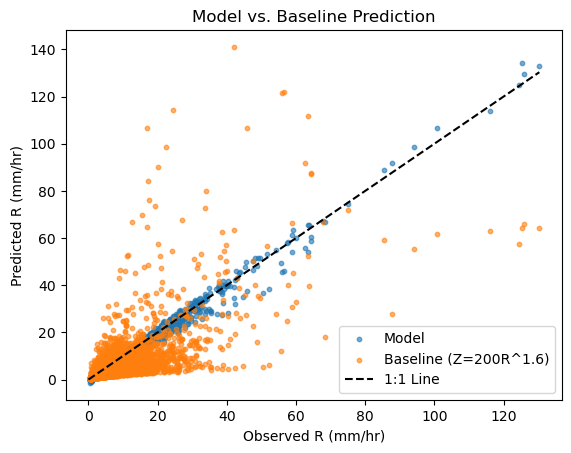

In [5]:
# Plot the results
plt.scatter(y2, y2_model, s=10, alpha=0.6, label='Model')
plt.scatter(y2, R_test, s=10, alpha=0.6, label='Baseline (Z=200R^1.6)')
plt.plot([0, y2.max()], [0, y2.max()], 'k--', label='1:1 Line')
plt.xlabel('Observed R (mm/hr)')
plt.ylabel('Predicted R (mm/hr)')
plt.legend()
plt.title('Model vs. Baseline Prediction')
plt.show()

(3) Repeat 1 doing a grid search over polynomial orders, using a grid search over orders 0-9, and use cross-validation of 7 folds. For the best polynomial model in terms of R2, does it outperform the baseline and the linear regression model in terms of R2 and root mean square error?

In [6]:
# Create polynomial regression pipeline
# Define the grid of polynomial degrees 0-9
# Use cross-validation of 7 folds
# Perform grid search
poly_model = make_pipeline(PolynomialFeatures(), LinearRegression())
param_grid = {'polynomialfeatures__degree': np.arange(0, 10)}
grid = GridSearchCV(poly_model, param_grid, cv=7, scoring='r2')
grid.fit(X1, y1)

# Get the best model
best_degree = grid.best_params_['polynomialfeatures__degree']
best_model = grid.best_estimator_
print(f"Best polynomial degree: {best_degree}")

# Evaluate on test data
y2_poly = best_model.predict(X2)

# Compute R2 and RMSE
r2_poly = r2_score(y2, y2_poly)
rmse_poly = np.sqrt(mean_squared_error(y2, y2_poly))
print(f"Polynomial (degree={best_degree}) R²: {r2_poly}")
print(f"Polynomial (degree={best_degree}) RMSE: {rmse_poly}")

# Compare to baseline model
rmse_test = np.sqrt(mean_squared_error(y2_poly, R_test))
r2_test = r2_score(y2_poly, R_test)
print(f"Root Mean Squared Error between testing and R: {rmse_test}")
print(f"R-squared between testing and R: {r2_test}")

Best polynomial degree: 2
Polynomial (degree=2) R²: 0.99943395027317
Polynomial (degree=2) RMSE: 0.1989099694479065
Root Mean Squared Error between testing and R: 7.340596940684554
R-squared between testing and R: 0.22815366212241805


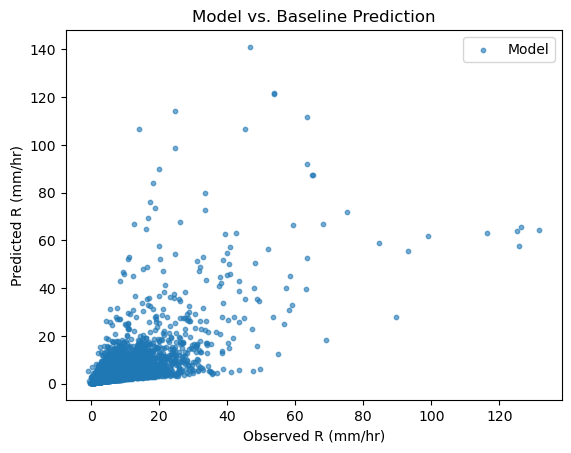

In [7]:
# Plot the results
plt.scatter(y2_poly, R_test, s=10, alpha=0.6, label='Model')
plt.xlabel('Observed R (mm/hr)')
plt.ylabel('Predicted R (mm/hr)')
plt.legend()
plt.title('Model vs. Baseline Prediction')
plt.show()

(4) Repeat 1 with a Random Forest Regressor, and perform a grid_search on the following parameters:

In [8]:
from sklearn.ensemble import RandomForestRegressor
# Define hyperparameters
param_grid = {
 "bootstrap": [True, False],
 "max_depth": [10, 100],
 "max_features": ["sqrt", 1.0],  
 "min_samples_leaf": [1, 4],
 "min_samples_split": [2, 10],
 "n_estimators": [200, 1000]}

grid_rf = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, scoring='r2', cv=7, n_jobs=-1)
grid_rf

GridSearchCV(cv=7, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [10, 100],
                         'max_features': ['sqrt', 1.0],
                         'min_samples_leaf': [1, 4],
                         'min_samples_split': [2, 10],
                         'n_estimators': [200, 1000]},
             scoring='r2')

In [9]:
# Fit the grid
#Zh_train = np.reshape(Zh_train, (-1, 1))
grid_rf.fit(X1, y1)

/data/keeling/a/mgraber2/miniconda3/lib/python3.9/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=7, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [10, 100],
                         'max_features': ['sqrt', 1.0],
                         'min_samples_leaf': [1, 4],
                         'min_samples_split': [2, 10],
                         'n_estimators': [200, 1000]},
             scoring='r2')

In [11]:
# Fit the model
model_rf = grid_rf.best_estimator_
model_rf.fit(X1, y1)
y1_rf = model_rf.predict(X1)
y2_rf = model_rf.predict(X2)

In [12]:
# Calculate r2 and rmse
r2_rf_train = r2_score(y1, y1_rf)
rmse_rf_train = np.sqrt(mean_squared_error(y1, y1_rf))
r2_rf_test = r2_score(y2, y2_rf)
rmse_rf_test = np.sqrt(mean_squared_error(y2, y2_rf))

print('Random Forest Model Training R2: ', r2_rf_train)
print('Random Forest Model Training RMSE: ', rmse_rf_train)
print('Random Forest Model Testing R2: ', r2_rf_test)
print('Random Forest Model Testing RMSE: ', rmse_rf_test)

Random Forest Model Training R2:  0.996784984303047
Random Forest Model Training RMSE:  0.49084251452578637
Random Forest Model Testing R2:  0.9543274787682577
Random Forest Model Testing RMSE:  1.786721038789986
